# Chapter-1-2-기본과제


In [1]:
!pip install datasets
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.8 MB/s eta 0:00:00ta 0:00:01


In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn
)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


##  Multi-head attention(MHA) 구현

Self-attention module을 MHA로 확장해주시면 됩니다. 여기서 MHA는 다음과 같이 구현합니다.
1. 기존의 $W_q, W_k, W_v$를 사용하여 $Q, K, V$를 생성합니다. 이 부분은 코드 수정이 필요 없습니다.

    a. $Q, K, V \in \mathbb{R}^{S \times D}$가 있을 때, 이를 $Q, K, V \in \mathbb{R}^{S \times H \times D’}$으로 reshape 해줍니다. 여기서 $H$는 `n_heads`라는 인자로 받아야 하고, $D$가 $H$로 나눠 떨어지는 값이여야 하는 제약 조건이 필요합니다. $D = H \times D’$입니다.

    b. $Q, K, V$를 $Q, K, V \in \mathbb{R}^{H \times S \times D’}$의 shape으로 transpose해줍니다.
2. $A = QK^T/\sqrt{D'} \in \mathbb{R}^{H \times S \times S}$를 기존의 self-attention과 똑같이 계산합니다. 이 부분은 코드 수정이 필요 없습니다.
3. Mask를 더합니다. 기존과 $A$의 shape이 달라졌기 때문에 dimension을 어떻게 맞춰줘야할지 생각해줘야 합니다.
4. $\hat{x} = \textrm{Softmax}(A)V \in \mathbb{R}^{H \times S \times D'}$를 계산해주고 transpose와 reshape을 통해 $\hat{x} \in \mathbb{R}^{S \times D}$의 shape으로 다시 만들어줍니다.
5. 기존과 똑같이 $\hat{x} = \hat{x} W_o$를 곱해줘서 마무리 해줍니다. 이 또한 코드 수정이 필요 없습니다.

In [3]:
from torch import nn
from math import sqrt

# Multi-head attention(MHA) 구현
class MultiSelfAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    batch_size, seq_len, _ = x.size()

    # 선형 변환의 결과를 multi-head attention을 위한 shape 변경
    q = self.wq(x).view(batch_size, seq_len, self.n_heads, self.d_head)
    k = self.wk(x).view(batch_size, seq_len, self.n_heads, self.d_head)
    v = self.wv(x).view(batch_size, seq_len, self.n_heads, self.d_head)

    # transpose 적용
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    # Attention score 계산
    score = torch.matmul(q, k.transpose(-2, -1)) / sqrt(self.d_head)

    # mask 적용
    if mask is not None:
      score = score + (mask.unsqueeze(1)  * -1e9)

    # softmax 계산
    score = self.softmax(score)
    result = torch.matmul(score, v)

    # Multi-head attention 결과를 원래 shape으로 변경
    result = result.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
    result = self.dense(result)

    return result


## Layer normalization, dropout, residual connection 구현
    - 다시 `TransformerLayer` class로 돌아와서 과제를 진행하시면 됩니다.
    - Attention module을 $MHA$, feed-forward layer를 $FFN$이라고 하겠습니다.
    - 기존의 구현은 다음과 같습니다:
        
        ```python
        # x, mask is given
        
        x1 = MHA(x, mask)
        x2 = FFN(x1)
        
        return x2
        ```
        
    - 다음과 같이 수정해주시면 됩니다.
        
        ```python
        # x, mask is given
        
        x1 = MHA(x, mask)
        x1 = Dropout(x1)
        x1 = LayerNormalization(x1 + x)
        
        x2 = FFN(x1)
        x2 = Dropout(x2)
        x2 = LayerNormalization(x2 + x1)
        
        return x2
        
    - 여기서 `x1 + x`와 `x2 + x1`에 해당하는 부분들은 residual connection이라고 부릅니다.

In [4]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, n_heads):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff
    self.Dropout1 = nn.Dropout(p=0.1)
    self.Dropout2 = nn.Dropout(p=0.1)    
    self.LayerNormalization1 = nn.LayerNorm(d_model)
    self.LayerNormalization2 = nn.LayerNorm(d_model)
    

    self.mha = MultiSelfAttention(input_dim, d_model, n_heads)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )


  def forward(self, x, mask):
    x1 = self.mha(x, mask)
    x1 = self.Dropout1(x1)
    x1 = self.LayerNormalization1(x1 + x)

    x2 = self.ffn(x1)
    x2 = self.Dropout2(x2)
    x2 = self.LayerNormalization2(x2 + x1)

    return x2

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [5]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


##  5-layer 4-head Transformer
- 기존 실습에서 사용한 hyper-parameter들과 위에서 구현한 Transformer를 가지고 5-layer 4-head Transformer의 성능 결과를 report해주시면 됩니다.

In [6]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, n_heads) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 2)#1

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x

# 5-layer 4-head Transformer
model = TextClassifier(len(tokenizer), 32, 5, 32, 4)

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [7]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

Epoch   0 | Train Loss: 199.8312447965145
=========> Train acc: 0.840 | Test acc: 0.808
Epoch   1 | Train Loss: 142.4368855804205
=========> Train acc: 0.887 | Test acc: 0.831
Epoch   2 | Train Loss: 116.3493375480175
=========> Train acc: 0.916 | Test acc: 0.835
Epoch   3 | Train Loss: 94.3651879504323
=========> Train acc: 0.922 | Test acc: 0.830
Epoch   4 | Train Loss: 75.89393257722259
=========> Train acc: 0.946 | Test acc: 0.823
Epoch   5 | Train Loss: 57.67631744593382
=========> Train acc: 0.976 | Test acc: 0.835
Epoch   6 | Train Loss: 44.34849110431969
=========> Train acc: 0.981 | Test acc: 0.833
Epoch   7 | Train Loss: 36.902394582517445
=========> Train acc: 0.985 | Test acc: 0.827
Epoch   8 | Train Loss: 29.520255205221474
=========> Train acc: 0.982 | Test acc: 0.826
Epoch   9 | Train Loss: 24.7177407653071
=========> Train acc: 0.992 | Test acc: 0.830
Epoch  10 | Train Loss: 21.32658224320039
=========> Train acc: 0.989 | Test acc: 0.822
Epoch  11 | Train Loss: 20.30376

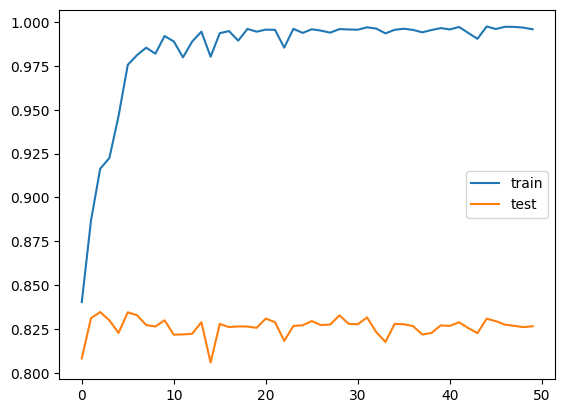

In [9]:
n_epochs = 50
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
    train_accs.append(train_acc)
    test_accs.append(test_acc)

plot_acc(train_accs, test_accs)